# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install -U -q scikit-learn

import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, make_scorer
from math import sqrt

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
df = pd.read_csv('/datasets/autos.csv', delimiter=',', decimal='.')
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [3]:
df = df.rename(columns={'DateCrawled':'date_crawled','VehicleType':'vehicle_type', 'RegistrationYear':'registration_year', \
                        'RegistrationMonth':'registration_month', 'FuelType':'fuel_type', 'DateCreated':'date_created',\
                        'NumberOfPictures':'number_of_pictures', 'PostalCode':'postal_code', 'LastSeen':'last_seen'})
df = df.rename(columns=lambda x: x.lower())
df.head(15)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
df['date_crawled'].max()

'2016-04-07 14:36:58'

In [5]:
df['number_of_pictures'].unique()

array([0])

In [6]:
df.duplicated().sum()

4

Избавимся от колонки number_of_pictures, поскольку в ней только одно значение - 0, соответсвенно, пользы оно не несет.
На данный момент имеем 4 дубликата.
Также столбцы 'last_seen', 'date_crawled', 'registration_month', 'date_created', 'postal_code' - не влияют на предсказание стоимости автомобиля.

In [7]:
df.drop(columns=['number_of_pictures', 'last_seen', 'date_crawled', 'registration_month', 'date_created', 'postal_code'], axis= 1, inplace= True)
df.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Отметим, что столбцы vehicle_type, gearbox, model, fuel_type, repaired имеются пропуски.

In [9]:
df.describe()

,price,registration_year,power,kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


В числовых признаках содержатся неинформативные данные, значения max столбцов registration_year и power имеют нереальные значения. 

In [10]:
df.duplicated().sum()

45040

После удаления дат, количество дубликатов сильно увеличислоь. Скорее всего, некоторые объявления были загружены повторно, т.к. полное совпадение по остальным признаком очень маловероятно. Избавимся от таких записей.

In [11]:
df = df.drop_duplicates()
df[df.duplicated()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired


Изучим выбросы в данных.

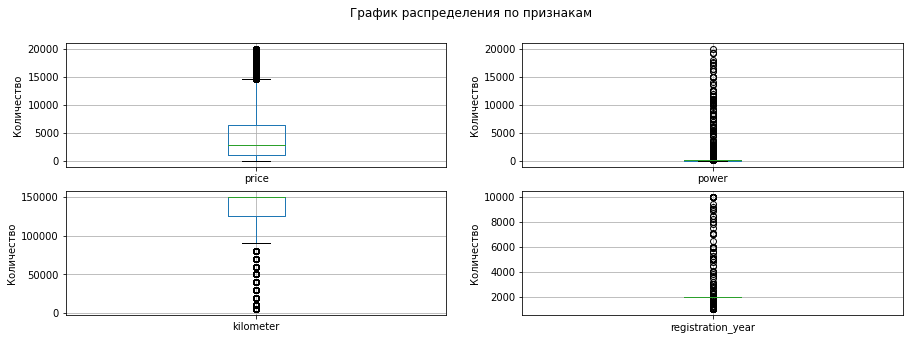

In [12]:
columns = ['price', 'power', 'kilometer', 'registration_year']
def boxplot_func(data, columns):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
    for i, column in enumerate(columns):
        row_index = i // 2
        col_index = i % 2
        data.boxplot(column=column, ax=axes[row_index, col_index])
    plt.suptitle('График распределения по признакам')
    for ax in axes:
        ax[0].set_ylabel('Количество')
        ax[1].set_ylabel('Количество')
boxplot_func(df, columns)

Очень много выбросов в столбцах registration_year и power, это явно опечатки и не валидные данные. Оставим следующие диапазоны: power - от 10 до 1000, registration_year с 1960 по 2024.

In [14]:
df_cut = df.query('10<power<1000 and 1960<registration_year<=2016 ') # т.к. последняя дата выгрузки '2016-04-07 14:36:58'

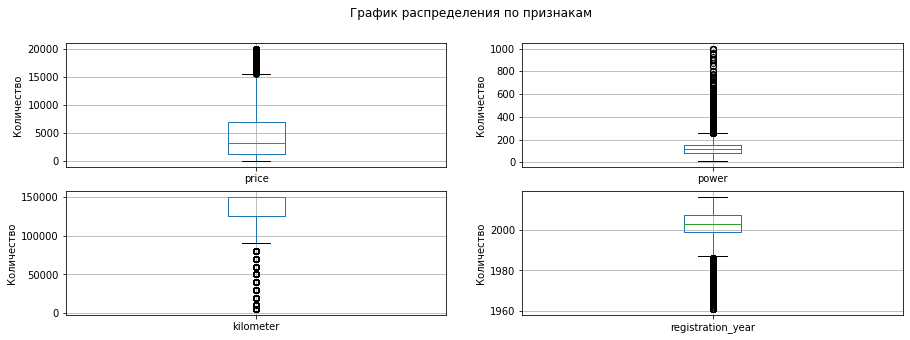

In [15]:
boxplot_func(df_cut, columns)

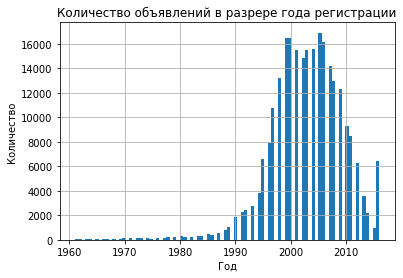

In [16]:
df_cut[['registration_year']]['registration_year'].hist(bins = 90)
plt.title('Количество объявлений в разрере года регистрации')
plt.xlabel('Год')
plt.ylabel('Количество');

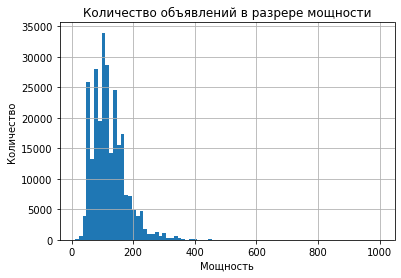

In [17]:
df_cut[['power']]['power'].hist(bins = 80)
plt.title('Количество объявлений в разрере мощности')
plt.xlabel('Мощность')
plt.ylabel('Количество');

Взглянем на пропуски

In [18]:
df_cut.isnull().sum()

price                    0
vehicle_type         11405
registration_year        0
gearbox               5509
power                    0
model                11278
kilometer                0
fuel_type            16155
brand                    0
repaired             41685
dtype: int64

In [19]:
df_cut[df_cut['vehicle_type'].isnull()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
35,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no
52,1400,NaN,2016,manual,55,other,5000,NaN,hyundai,NaN
71,2300,NaN,1997,manual,150,5er,150000,NaN,bmw,no
...,...,...,...,...,...,...,...,...,...,...
354158,0,NaN,2000,manual,55,punto,5000,petrol,fiat,yes
354175,0,NaN,1995,manual,45,polo,150000,petrol,volkswagen,NaN
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354351,1900,NaN,2000,manual,110,NaN,150000,NaN,volkswagen,no


In [20]:
df_cut[df_cut['vehicle_type'].isnull()].groupby('brand').count().sort_values(by='price', ascending=False).head(7)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
brand,,,,,,,,,
volkswagen,3240,0,3240,2803,3240,2838,3240,1972,1508
opel,1601,0,1601,1397,1601,1411,1601,879,824
ford,924,0,924,804,924,807,924,507,494
bmw,845,0,845,776,845,640,845,408,459
audi,816,0,816,719,816,669,816,462,421
mercedes_benz,627,0,627,573,627,528,627,365,337
renault,604,0,604,533,604,544,604,356,309


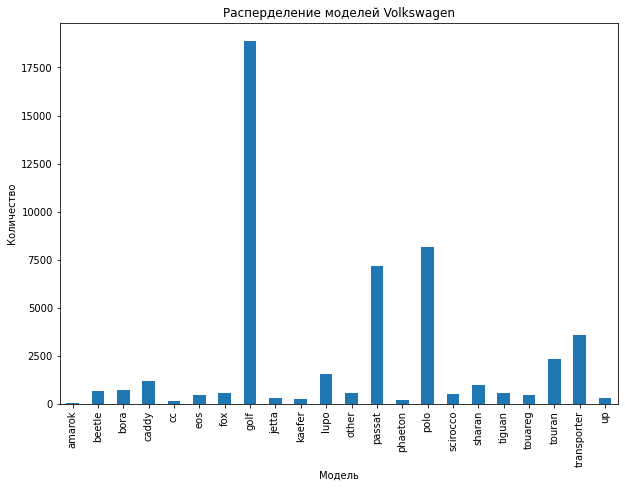

In [21]:
df_cut[df_cut['brand'] == 'volkswagen'].groupby('model')['vehicle_type'].count().plot(kind='bar', figsize = (10, 7))
plt.title('Расперделение моделей Volkswagen')
plt.xlabel('Модель')
plt.ylabel('Количество');

In [22]:
df_cut['vehicle_type'].value_counts(dropna=False)

sedan          72346
small          59906
wagon          52153
bus            23687
convertible    17041
coupe          13633
NaN            11405
suv             9925
other           2457
Name: vehicle_type, dtype: int64

In [23]:
models = df_cut[~df_cut['model'].isna()]['model'].unique()
models

array(['grand', 'golf', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       'astra', '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'ka',
       'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er',
       'combo', 'corsa', '80', '147', 'meriva', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
      

Для каждой модели с неуказанным vehicle_type заменяем его на моду для данной модели

In [24]:
for model in models:
    df_cut.loc[(df_cut['vehicle_type'].isna()) & 
             (df_cut['model']==model),'vehicle_type'] = df_cut.loc[(df_cut['model']==model) & 
                                                               (~df_cut['vehicle_type'].isna()),'vehicle_type'].mode()[0]

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [25]:
df_cut.isnull().sum()

price                    0
vehicle_type          1732
registration_year        0
gearbox               5509
power                    0
model                11278
kilometer                0
fuel_type            16155
brand                    0
repaired             41685
dtype: int64

У нас осталовь 3017 пустых значений, поскольку имеются пропуски в 'model'. Так же пропуски в столбцах 'gearbox', 'fuel_type' и 'repaired', мы не можем логически их заполнить, поскольку они независимы от других признаков. Такие строки заполним значениями 'unknown'.

In [26]:
cols = ['model', 'gearbox', 'vehicle_type', 'fuel_type', 'repaired']
for column in cols:
    df_cut[column].fillna('unknown', inplace = True)
df_cut.isnull().sum()

/opt/conda/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Подготовка

Найдем количество 10 самых редких моделей.

In [27]:
df_pivot = df_cut.pivot_table(index='model', values='price', aggfunc='count').sort_values(by='price', ascending=True)
df_pivot.head(10)

,price
model,
range_rover_evoque,1
rangerover,2
serie_3,3
kalina,4
serie_2,4
samara,5
i3,5
elefantino,7
gl,11


In [28]:
models_to_other = df_pivot[df_pivot['price']<10].index.to_list()
df_cut.loc[df_cut['model'].isin(models_to_other),'model'] = 'other'
df_cut[df_cut['model'] == 'other']

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
24,500,sedan,1990,manual,118,other,150000,petrol,mercedes_benz,yes
38,11900,other,2002,manual,129,other,150000,gasoline,volkswagen,no
39,1500,bus,1984,manual,70,other,150000,gasoline,mercedes_benz,no
52,1400,sedan,2016,manual,55,other,5000,unknown,hyundai,unknown
...,...,...,...,...,...,...,...,...,...,...
354239,1000,bus,2001,manual,121,other,150000,petrol,daewoo,no
354240,890,bus,1999,manual,67,other,125000,gasoline,fiat,no
354286,16500,coupe,1973,manual,200,other,150000,petrol,bmw,yes
354290,2500,small,2007,manual,60,other,125000,petrol,hyundai,unknown


In [29]:
# избавимся от значений price = 0
df_cut = df_cut[df_cut['price']!=0]

## Обучение моделей

In [30]:
X = df_cut.drop(['price'], axis=1)
y = df_cut['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=X['model'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((192848, 9), (64283, 9), (192848,), (64283,))

In [31]:
# списки с названиями признаков
ohe_columns = ['model',
               'brand',
               'vehicle_type',
               'gearbox',
               'fuel_type',
               'repaired']

num_columns = ['registration_year',
               'power',
               'kilometer']

In [34]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)


# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', StandardScaler())
])

In [35]:
param_grid = [
    
    # словарь для модели LinearRegression
    {'models': [LinearRegression()],
     'models__fit_intercept': [True, False],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    # словарь для модели DecisionTreeRegressor
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': (None, *range(2,8)),
     'models__max_features': range(2,30),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    
    #словарь для модели RandomForestRegressor
    {'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
     'models__n_estimators': range(2,8),
     'models__max_depth': range(2,10),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    
    #словарь для модели LGBMRegressor
    {'models': [LGBMRegressor(random_state=RANDOM_STATE)],
     'models__n_estimators': [1000, 1200],
     'models__learning_rate': [0,10],
     'models__max_depth': [12, 14],
     'preprocessor__num': [StandardScaler(), 'passthrough']}
]

In [36]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=False
)

## Анализ моделей

In [38]:
%%time

rs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', rs.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['model', 'brand',
                                                   'vehicle_type', 'gearbox',
                                                   'fuel_type', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                           

In [39]:
model_params = []

for model in rs.cv_results_['param_models']:
    print(model)
    print(model.get_params())
    model_params.append(model.get_params())
    print()

RandomForestRegressor(random_state=42)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

RandomForestRegressor(random_state=42)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

RandomForestRegressor(random_state=42)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None

In [40]:
models_df = pd.DataFrame({'name': [], 'params': [], 'mean_fit_time':[], 'mean_score_time':[], 'mean_test_score':[]})

In [41]:
models_df['name'] = rs.cv_results_['param_models']
models_df['params'] = model_params
models_df['mean_fit_time'] = rs.cv_results_['mean_fit_time']
models_df['mean_score_time'] = rs.cv_results_['mean_score_time']
models_df['mean_test_score'] = rs.cv_results_['mean_test_score']
models_df['rank_test_score'] = rs.cv_results_['rank_test_score']
models_df

,name,params,mean_fit_time,mean_score_time,mean_test_score,rank_test_score
0,RandomForestRegressor(random_state=42),"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",15.141082,0.309894,-2.076609e+03,1
1,RandomForestRegressor(random_state=42),"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",6.364844,0.292149,-2.286457e+03,4
2,RandomForestRegressor(random_state=42),"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",9.048929,0.295349,-2.083077e+03,2
3,RandomForestRegressor(random_state=42),"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",4.199798,0.274992,-2.439228e+03,5
4,DecisionTreeRegressor(random_state=42),"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1.336576,0.268285,-3.517250e+03,7
5,DecisionTreeRegressor(random_state=42),"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",2.322585,0.292539,-2.200229e+03,3
6,DecisionTreeRegressor(random_state=42),"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1.421488,0.283535,-3.507488e+03,6
7,DecisionTreeRegressor(random_state=42),"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1.155556,0.267335,-4.591807e+03,9
8,LGBMRegressor(random_state=42),"{'boosting_type': 'gbdt', 'class_weight': None...",183.788449,0.391961,-8.107822e+38,10
9,DecisionTreeRegressor(random_state=42),"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1.121286,0.257909,-3.666854e+03,8


In [42]:
%%time
model = rs.best_estimator_
model.fit(X_train, y_train) #замеряем время обучения лучшей модели

CPU times: user 17.6 s, sys: 639 ms, total: 18.3 s
Wall time: 18.3 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  ['model', 'brand',
                                                   'vehicle_type', 'gearbox',
                                                   'fuel_type', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('models',
                 RandomForestRegressor(max_depth=8, n_estimators=7,
                                       random_state=42))])

In [43]:
%%time
model.predict(X_train) #замеряем время предсказания

CPU times: user 777 ms, sys: 651 ms, total: 1.43 s
Wall time: 1.43 s


array([6609.70746047, 1637.46621282, 4141.09458694, ..., 3335.3663699 ,
       7975.01222149, 7642.69973509])

In [44]:
%%time
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

CPU times: user 238 ms, sys: 243 ms, total: 481 ms
Wall time: 487 ms


2078.424342008629